In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time as t

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsOneClassifier

In [2]:
# Loading data
path = '/Users/tristangarcia/desktop/Network Traffic Classification/data/final/'

pca_train = pd.read_pickle(f'{path}pcatrain.pkl').reset_index(drop=True)
x_train = pd.read_pickle(f'{path}xtrain.pkl').reset_index(drop=True)
y_train = pd.read_pickle(f'{path}ytrain.pkl').reset_index(drop=True).squeeze()
y2_train = pd.read_pickle(f'{path}y2train.pkl').reset_index(drop=True).squeeze()

pca_test = pd.read_pickle(f'{path}pcatest.pkl').reset_index(drop=True)
x_test = pd.read_pickle(f'{path}xtest.pkl').reset_index(drop=True)
y_test = pd.read_pickle(f'{path}ytest.pkl').reset_index(drop=True).squeeze()
y2_test = pd.read_pickle(f'{path}y2test.pkl').reset_index(drop=True).squeeze()

In [3]:
# target labels
s1_labels = ['normal', 'attack']
s2_labels = ['analysis', 'backdoor', 'dos', 'exploits', 'fuzzers', 'generic', 
          'normal', 'reconnaissance', 'shellcode', 'worms'] 

In [4]:
# Classifiers
pca_clf1 = XGBClassifier(max_depth=32, min_child_weight=1,
                         colsample_bytree=1, subsample=1, 
                         n_estimators=100)
full_clf1 =XGBClassifier(max_depth=32, min_child_weight=1,
                         colsample_bytree=1, subsample=1, 
                         n_estimators=200)
clf2 = OneVsOneClassifier(XGBClassifier())

# Utility functions

In [5]:
def clf_pipeline(clf1,clf2,x_train, y_train,y2_train,x_test):
    s_time = t.time()
    final_pred = pd.Series(None, index=x_test.index)
    # Training and predicting Stage1
    clf1.fit(x_train, y_train)
    y_pred = clf1.predict(x_test)
    # Prediction indices
    normal_pred_indices = [i for i, pred in enumerate(y_pred) if pred == 0]
    attack_pred_indices = [i for i, pred in enumerate(y_pred) if pred == 1]
    # Only passing predicted attack to second stage
    x_test = x_test.iloc[attack_pred_indices]
    # Training and predicting Stage2
    clf2.fit(x_train, y2_train)
    y2_pred = clf2.predict(x_test)
    # Final Predictions
    final_pred.iloc[normal_pred_indices] = 6     # Labelencoded value for normal traffic
    final_pred.iloc[attack_pred_indices] = y2_pred
    # Total time
    e_time = t.time()    # End time
    print(f'Total time taken: {(e_time - s_time):.2f} seconds')

    return y_pred, final_pred

In [6]:
def display_results(y_true, y_pred, labels):
    # Evaluation metrics
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0, digits=4))
    # Confustion matrix
    test_cmap=sns.light_palette("blue")
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap=test_cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

## PCA training set

In [7]:
s1_pca_pred, s2_pca_pred = clf_pipeline(pca_clf1, clf2, pca_train, y_train, y2_train, pca_test)

Total time taken: 33.94 seconds


              precision    recall  f1-score   support

      normal     0.9955    0.9945    0.9950     52673
      attack     0.9782    0.9822    0.9802     13334

    accuracy                         0.9920     66007
   macro avg     0.9868    0.9883    0.9876     66007
weighted avg     0.9920    0.9920    0.9920     66007



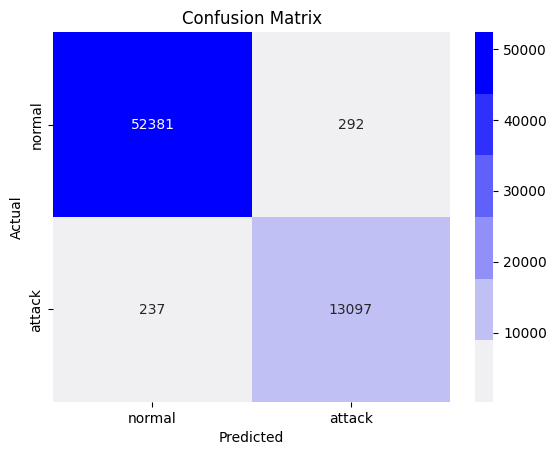

In [8]:
display_results(y_test, s1_pca_pred, s1_labels)

                precision    recall  f1-score   support

      analysis     0.3333    0.0198    0.0374       101
      backdoor     0.0000    0.0000    0.0000       100
           dos     0.3388    0.3342    0.3365       736
      exploits     0.5997    0.7395    0.6623      1716
       fuzzers     0.7316    0.5767    0.6450       808
       generic     0.9959    0.9800    0.9879      9282
        normal     0.9923    0.9969    0.9946     52673
reconnaissance     0.7931    0.6522    0.7158       529
     shellcode     0.6667    0.4364    0.5275        55
         worms     1.0000    0.1429    0.2500         7

      accuracy                         0.9690     66007
     macro avg     0.6451    0.4879    0.5157     66007
  weighted avg     0.9678    0.9690    0.9677     66007



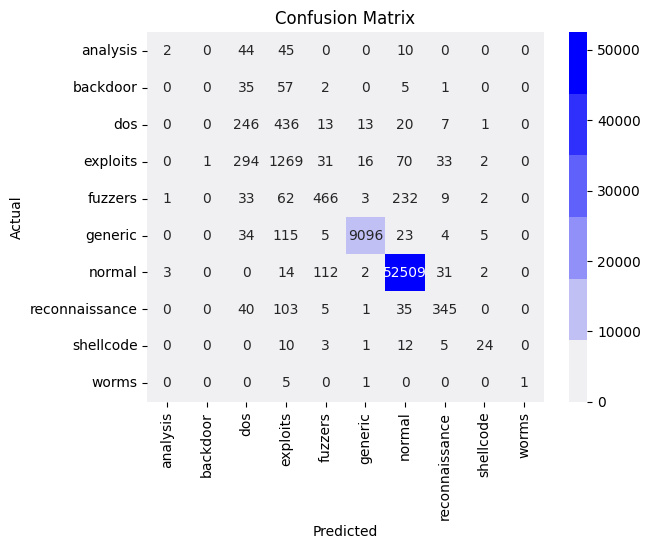

In [9]:
display_results(y2_test, s2_pca_pred, s2_labels)

In [10]:
s1_full_pred, s2_full_pred = clf_pipeline(full_clf1, clf2, x_train, y_train, y2_train, x_test)

Total time taken: 88.95 seconds


## Full training set

              precision    recall  f1-score   support

      normal     0.9969    0.9965    0.9967     52673
      attack     0.9862    0.9879    0.9871     13334

    accuracy                         0.9948     66007
   macro avg     0.9916    0.9922    0.9919     66007
weighted avg     0.9948    0.9948    0.9948     66007



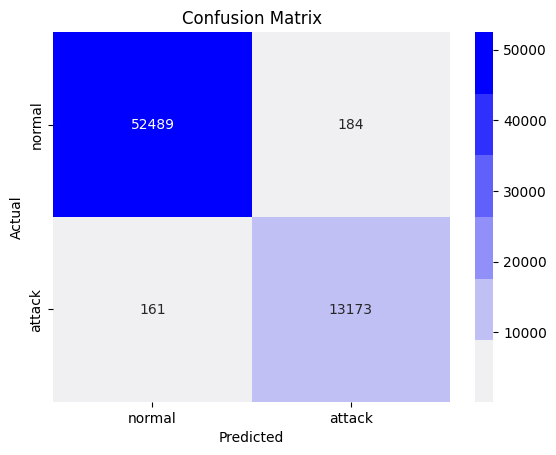

In [11]:
display_results(y_test, s1_full_pred, s1_labels)

                precision    recall  f1-score   support

      analysis     0.5000    0.0198    0.0381       101
      backdoor     0.7500    0.0300    0.0577       100
           dos     0.3690    0.3655    0.3672       736
      exploits     0.6217    0.7786    0.6913      1716
       fuzzers     0.8471    0.6584    0.7409       808
       generic     0.9960    0.9838    0.9899      9282
        normal     0.9952    0.9983    0.9968     52673
reconnaissance     0.8920    0.7335    0.8050       529
     shellcode     0.6875    0.6000    0.6408        55
         worms     1.0000    0.2857    0.4444         7

      accuracy                         0.9739     66007
     macro avg     0.7658    0.5454    0.5772     66007
  weighted avg     0.9746    0.9739    0.9729     66007



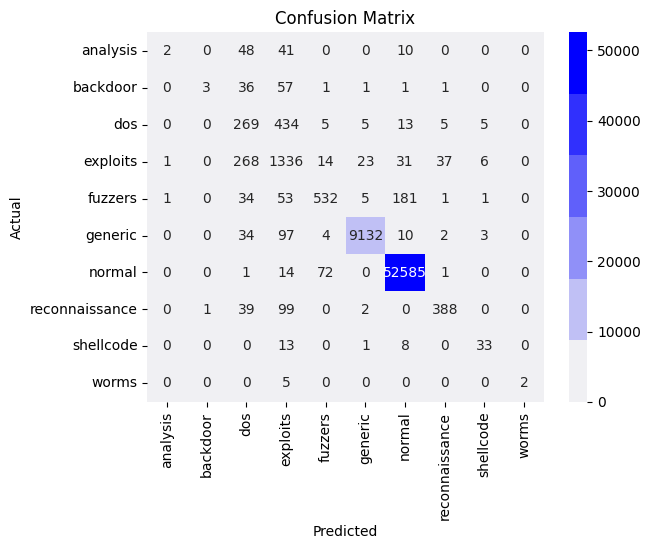

In [12]:
display_results(y2_test, s2_full_pred, s2_labels)